# Get data

In [1]:
import os
import pandas as pd
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, MinMaxScaler, normalize
from sklearn.decomposition import TruncatedSVD
import numpy as np
import my_utils
import gzip
import shutil
from sklearn.pipeline import Pipeline

In [ ]:
input_gz_file = '../Output/GSE185948_count_RNA.rds.gz'
output_rds_file = '../Output/data_for_r.rds'

# Open the compressed file and extract it
with gzip.open(input_gz_file, 'rb') as f_in, open(output_rds_file, 'wb') as f_out:
    shutil.copyfileobj(f_in, f_out)

print(f'{input_gz_file} has been successfully uncompressed to {output_rds_file}.')

In [ ]:
input_gz_file = '../Output/GSE185948_metadata_RNA.csv.gz'
output_csv_file = '../Output/uncompressed_metadata.csv'

# Open the compressed file and extract it
with gzip.open(input_gz_file, 'rb') as f_in, open(output_csv_file, 'wb') as f_out:
    shutil.copyfileobj(f_in, f_out)

print(f'{input_gz_file} has been successfully uncompressed to {output_csv_file}.')

In [ ]:
output_path = '../Output'
if not os.path.exists(output_path):
    os.makedirs(output_path)

In [2]:
metadata = pd.read_csv('../Output/uncompressed_metadata.csv')

R code below

transpose_test## Data Preparation

In [ ]:
pip install --upgrade --no-deps memory_profiler

In [75]:
data_path = '../Output/non_zero.parquet'
row_info_path = '../Output/row_names.csv'
column_info_path = '../Output/col_names.csv'
#sparse_matrix = coo_matrix((data['nonzero_elements'], (data['row_indices'], data['col_indices'])))
sparse_matrix, column_names, row_names, row_indices= my_utils.load_data(data_path, row_info_path, column_info_path)

Returning sparse_matrix, column_names, row_names, and row_indices


In [78]:
transpose_test = sparse_matrix.transpose()

In [82]:
row_indices_test = np.arange(transpose_test.shape[0])

In [83]:
row_indices_test

array([     0,      1,      2, ..., 102707, 102708, 102709])

In [ ]:
split_pipeline = Pipeline([
    ('splitter', my_utils.SparseTrainTestSplit(test_size=0.2, random_state=42, row_indices = row_indices)),
    # Add other steps in the pipeline as needed
])

# Fit and transform the pipeline
sparse_train, sparse_test, train_indices, test_indices = split_pipeline.fit_transform(sparse_matrix)


In [ ]:
sparse_train

In [ ]:
clean_and_pca_pipeline = Pipeline([
    ('cleaner', my_utils.DataClean()),  # CleanData is performed first
    ('scaler', StandardScaler(with_mean=False)),
    ('pca', TruncatedSVD(n_components=2))
])

# Fit the pipeline to training
clean_and_pca_pipeline.fit(sparse_train)
# Transform the training data
pca_sparse_train = clean_and_pca_pipeline.transform(sparse_train)

pca_sparse_test = clean_and_pca_pipeline.transform(sparse_test)

In [ ]:
reindexer = my_utils.Reindex(columns=["PC1", "PC2"], names=row_names, output_folder="../Output")
train_pca_df = reindexer.transform(pca_sparse_train, train_indices, "train")
test_pca_df = reindexer.transform(pca_sparse_test, test_indices, "test")

In [ ]:
eda_pca = my_utils.DataEDAPCA(columns=["PC1", "PC2"], trans=False, graphs=True)
pca_train_df, metadata_empty, outlier_df = eda_pca.fit_transform(train_pca_df)

## Clustering on the Train Data

In [ ]:
pca_train_df = pd.read_csv('../Output/pca_train_df_without_outliers.csv', index_col = 0)
pca_test_df =  pd.read_csv('../Output/pca_test_df.csv', index_col=0)

In [ ]:
import time
from sklearn.metrics import silhouette_score

# Start timing
start_time = time.time()

# Your existing code for HDBSCAN clustering
hdbscan_params = {
    'min_samples': [10, 30, 50, 60, 100],
    'min_cluster_size': [100, 200, 300, 400, 500, 600],
    'cluster_selection_method': ['eom', 'leaf'],
    'metric': ['euclidean', 'manhattan']
}
# Create a pipeline
hdbscan_pipe = Pipeline([
    ("clusterer", my_utils.Optimize_and_Compare_Hdbscan(hdbscan_params)),
])

results_hbd = hdbscan_pipe.fit(pca_train_df)
best_estimator_hbd = results_hbd.named_steps['clusterer'].best_estimator

try:
    # Calculate silhouette score for test data
    silhouette_test_hbd = silhouette_score(pca_test_df, best_estimator_hbd.fit_predict(pca_test_df))
    print(f'Silhouette Score on test data: {silhouette_test_hbd}')
except ValueError as e:
    print("Only one cluster for my test data set. HDBSCAN does not work well for this data set")
end_time = time.time()
elapsed_time = end_time - start_time
silhouette_train_hbd = silhouette_score(pca_train_df, best_estimator_hbd.labels_)
print(f'Silhouette Score on training data: {silhouette_train_hbd}')
print(f'Time taken: {elapsed_time / 60:.2f} minutes')

In [ ]:
list_predictions = best_estimator_hbd.fit_predict(pca_test_df)

In [ ]:
import time
# Start timing
start_time = time.time()
kmeans_params = {
    'n_clusters': list(range(1, 10)),
    'init': ['random', 'k-means++'],
    'n_init': [1, 5, 10],
    'max_iter': [300],
    'random_state': [0]
}

# Create a pipeline
k_means_pipe = Pipeline([
    ("clusterer", my_utils.OptimizeAndCompareKMeans(kmeans_params)),
])

results = k_means_pipe.fit(pca_train_df)
best_estimator = results.named_steps['clusterer'].best_estimator
predictions_test = best_estimator.predict(pca_test_df)

from sklearn.metrics import silhouette_score

# Assuming you have already fitted the pipeline and obtained the best_estimator

# For training data
silhouette_train = silhouette_score(pca_train_df, best_estimator.labels_)

# For test data
silhouette_test = silhouette_score(pca_test_df, best_estimator.predict(pca_test_df))

# Stop timing
end_time = time.time()
elapsed_time = end_time - start_time

print(f'Silhouette Score on training data: {silhouette_train}')
print(f'Silhouette Score on test data: {silhouette_test}')
print(f'Time taken: {elapsed_time / 60:.2f} minutes')

I will use the Kmeans as my best estimator.

In [ ]:
scoring_df_untransposed = my_utils.create_labels_and_scoring_df(best_estimator, '../Output/best_estimator_untransposed_data_label_and_score', pca_train_df, pca_test_df)

In [ ]:
# Use your best_estimator to predict labels for the data
cluster_labels = best_estimator.predict(pca_train_df)

# Add the cluster_labels to the training data DataFrame
pca_train_df['Cluster'] = cluster_labels

# Create a scatter plot to visualize the clustering
plt.figure(figsize=(8, 6))
sns.scatterplot(x='PC1', y='PC2', data=pca_train_df, hue='Cluster', palette='viridis', s=50, alpha=0.7)

# Add labels and title
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('Clustering Visualization')

# Show the plot
plt.grid(True)
plt.legend(title='Cluster', loc='upper right')
plt.show()

https://towardsdatascience.com/tuning-with-hdbscan-149865ac2970

Things to consider


1) Get the clustering to work in a pipeline
2) Are these ok default parameters
3) What to do with the test data
4) Should we be using silhoute on grid search or should i be optimizaing it differently
5) Are we normalizing it the right way? Since normalize is working along rows is this dealing with out of domain sampels? Just used standard scalar because no normalizers could work and some of them did along rows
6) Make it so it put things in folders
7) Quality check NAS? How do to this with a sparse matrix
8) Do soemthing like she did in notebook 3 to label the data set
9) Naive classifier and base? 
10) Would k-means be base what is naive?


Transposed Data

Task 2

In [3]:
data_path = '../Output/non_zero.parquet'
row_info_path = '../Output/row_names.csv'
column_info_path = '../Output/col_names.csv'
#sparse_matrix = coo_matrix((data['nonzero_elements'], (data['row_indices'], data['col_indices'])))
sparse_matrix_trans, row_names_trans, col_names_trans, row_indices_trans= my_utils.load_data(data_path, row_info_path, column_info_path, transpose = True)

Returning Transposed matrix, row_names of the transposed matrix, col_names of the transposed matrix, and row_indices of transposed matrix


## Demographic Feature Cleaning for Training Data

In [4]:
cell_count = metadata['patient'].value_counts(normalize=True)
cell_count.columns = ['patient', 'percentage']
cell_count

PKD2        0.106241
PKD6        0.104167
control4    0.099338
control2    0.093009
PKD1        0.090575
PKD3        0.088687
PKD4        0.088112
PKD5        0.077879
control5    0.075679
control3    0.065193
control1    0.062428
PKD7        0.024428
PKD8        0.024262
Name: patient, dtype: float64

In [5]:
split_pipeline_trans = Pipeline([
    ('splitter', my_utils.PreserveRowIndicesSplitter(
        test_size=0.2, random_state=42,
        input_metadata=metadata, row_names=row_names_trans, groupby_columns=['gender', 'disease']
    )),
    # Add other steps in the pipeline as needed
])
(
    sparse_matrix_train_trans,
    sparse_matrix_test_trans,
    train_row_indices_trans,
    test_row_indices_trans
) = split_pipeline_trans.fit_transform(sparse_matrix_trans)


Subsetting metadata
Sending balanced sample to /Output/even_distribution_sample.csv


/Users/jacksongazin/Desktop/gradyear2/Data_Mining/Assignment4/Jackson-and-Anh-Data-Mining-Assingment-4/Scripts/my_utils.py:498: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  even_distribution_sample = even_distribution_sample.append(sampled_rows)
/Users/jacksongazin/Desktop/gradyear2/Data_Mining/Assignment4/Jackson-and-Anh-Data-Mining-Assingment-4/Scripts/my_utils.py:498: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  even_distribution_sample = even_distribution_sample.append(sampled_rows)
/Users/jacksongazin/Desktop/gradyear2/Data_Mining/Assignment4/Jackson-and-Anh-Data-Mining-Assingment-4/Scripts/my_utils.py:498: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  even_distribution_sample = even_distribution_sample.append(sample

Subsetting training data to be balanced data set


In [6]:
len(train_row_indices_trans)

46304

In [6]:
clean_and_pca_pipeline_trans = Pipeline([
    ('cleaner', my_utils.DataClean(trans=True)),  # Specify that the data is transposed
    ('scaler', StandardScaler(with_mean=False)),
    ('pca', TruncatedSVD(n_components=2))
])
# Fit the pipeline to training
clean_and_pca_pipeline_trans.fit(sparse_matrix_train_trans)
# Transform the training data
pca_sparse_train_trans = clean_and_pca_pipeline_trans.transform(sparse_matrix_train_trans)
pca_sparse_test_trans= clean_and_pca_pipeline_trans.transform(sparse_matrix_test_trans)

In [7]:
reindexer_trans = my_utils.Reindex(columns=["PC1", "PC2"], names=row_names_trans, output_folder="../Output", trans = True)
train_pca_df_trans = reindexer_trans.transform(pca_sparse_train_trans,  train_row_indices_trans, "train")
test_pca_df_trans = reindexer_trans.transform(pca_sparse_test_trans, test_row_indices_trans, "test")

Box Plot and Scatterplot of Data Set with Outliers


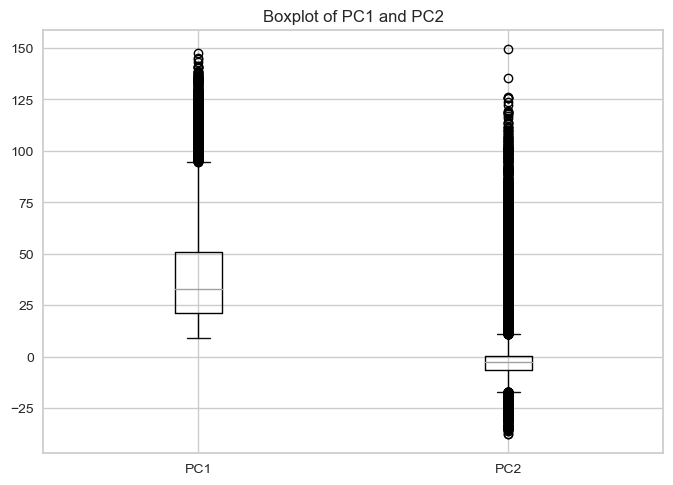

DataFrame of Z-scores sent to output folder
Z-threshold: 10
Df of Outliers sent to output folder
Removing 1 from our dataframe as they exceed our threshold of abs10
Sending updated Df to Output
Box Plot and Scatterplot of Data Set without Outliers


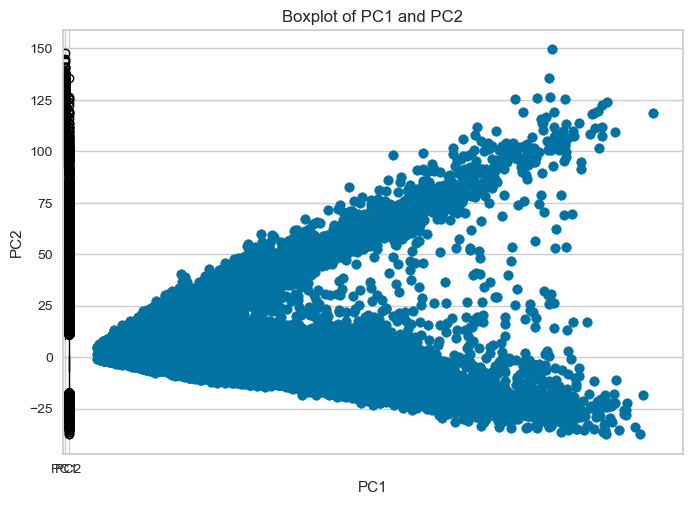

Returning updated dataframe, metadata of rows we removed, and PC of rows we removed


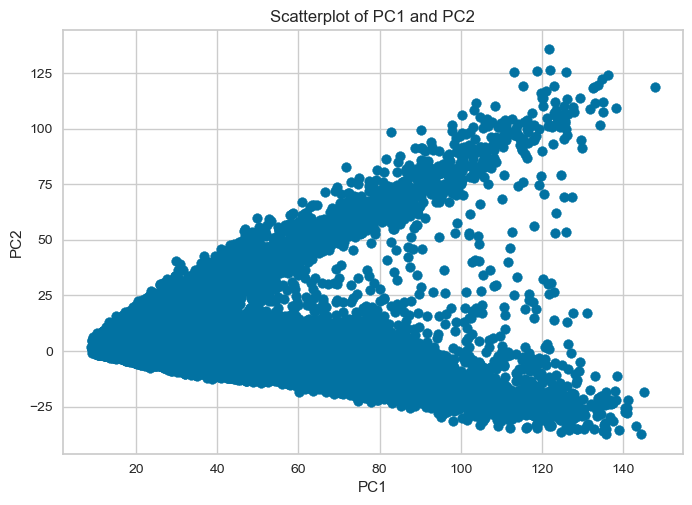

In [8]:
eda_pca = my_utils.DataEDAPCA(columns=["PC1", "PC2"], trans = True, graphs = True)
updated_train_pca_df_trans, metadata_removed, outlier_df_trans= eda_pca.fit_transform(train_pca_df_trans,another_df=  metadata)

Clustering on the Transposed Data

In [ ]:
import gzip
import os
import shutil
import pandas as pd
from pyarrow.parquet import read_table
from scipy.sparse import coo_matrix
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, MinMaxScaler, normalize
from sklearn.pipeline import Pipeline
import numpy as np
from sklearn.preprocessing import StandardScaler, MaxAbsScaler
from sklearn.decomposition import TruncatedSVD
from sklearn.base import BaseEstimator, TransformerMixin
from memory_profiler import memory_usage
import matplotlib.pyplot as plt
import seaborn as sns
from kneed import KneeLocator
from sklearn.datasets import make_blobs
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.metrics import adjusted_rand_score
from sklearn.model_selection import GridSearchCV
from yellowbrick.cluster import KElbowVisualizer, SilhouetteVisualizer
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.model_selection import GridSearchCV
from scipy import stats
from sklearn.cluster import HDBSCAN
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import silhouette_score
from scipy import stats
from sklearn.neighbors import LocalOutlierFactor
from sklearn.model_selection import train_test_split

# You can also define custom functions, classes, and other code in this module.

import pandas as pd
import numpy as np
from scipy.sparse import coo_matrix

In [ ]:
def silhouette_scorer(estimator, X):
    labels = estimator.fit_predict(X)
    if len(set(labels)) == 1:
        return 0  # Silhouette score is undefined for a single cluster
    return silhouette_score(X, labels)

def optimize_and_compare_hdbscan(data, hdbscan_params, alpha=0.05):
    # Perform Grid Search
    grid_search = GridSearchCV(
        estimator=HDBSCAN(min_cluster_size=20),
        param_grid=hdbscan_params,
        scoring=silhouette_scorer,
        cv=5,
        n_jobs=-1,
    )
    grid_search.fit(data)
    grid_search_estimator = grid_search.best_estimator_

    # Calculate silhouette scores for the default and grid search estimators
    default_hdbscan = HDBSCAN(min_cluster_size=20).fit(data)
    default_labels = default_hdbscan.labels_
    default_silhouette_score = silhouette_score(data, default_labels)

    grid_search_labels = grid_search_estimator.fit_predict(data)
    grid_search_silhouette_score = silhouette_score(data, grid_search_labels)

    # Check if the grid search estimator has a higher silhouette score
    if grid_search_silhouette_score > default_silhouette_score:
        # Perform a two-sample t-test
        t_stat, p_value = stats.ttest_ind(default_labels, grid_search_labels)

        # Check if the p-value is less than the significance level
        if p_value < alpha:
            choice = "Grid Search Estimator"
        else:
            choice = "Default Parameter"
    else:
        choice = "Default Parameter"

    # Output informative print statements
    print("Default HDBSCAN Silhouette Score:", default_silhouette_score)
    print("Grid Search Estimator Silhouette Score:", grid_search_silhouette_score)

    if grid_search_silhouette_score > default_silhouette_score:
        if p_value < alpha:
            print("The difference between the two groups is statistically significant.")
            print(f"Using {choice} as it performs significantly better.")
        else:
            print("The difference between the two groups is not statistically significant.")
            print(f"Using {choice} as there is no significant improvement.")
    else:
        print("Default Parameter has a higher silhouette score. No t-test performed.")

    return choice

# Define the parameter grid for HDBSCAN
hdbscan_params = {
    'min_samples': [10, 30, 50],
    'min_cluster_size': [100, 200, 300],
    'cluster_selection_method': ['eom', 'leaf'],
    'metric': ['manhattan']
}

# Usage example with parameters
result = optimize_and_compare_hdbscan(updated_train_pca_df_trans, hdbscan_params)